# XGBoost - Host - Boto3

## Download MNIST

In [1]:
%%time 
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 931 ms, sys: 355 ms, total: 1.29 s
Wall time: 2.71 s


In [2]:
!ls -l

total 15904
drwx------ 2 root     root        16384 May 22 02:10 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 16168813 May 22 05:28 mnist.pkl.gz
-rw-rw-r-- 1 ec2-user ec2-user     9143 May 22 05:28 SageMaker-XGBoost-Host-SMSDK.ipynb
-rw-rw-r-- 1 ec2-user ec2-user    84888 May 22 05:11 SageMaker-XGBoost.ipynb


## Explorer

This is a 5


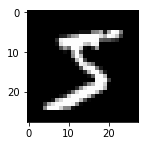

This is a 0


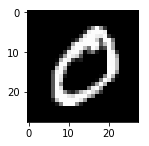

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 2):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

## Upload Data to S3

In [4]:
%%time

import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='bkt-sagemaker-source' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data

def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/test/examples
CPU times: user 38.5 s, sys: 5.75 s, total: 44.3 s
Wall time: 53.7 s


## Train a Model

### Create and Run a Training Job (AWS SDK for Python (Boto 3))

Obteniendo la imagen SageMaker XGBoost

In [5]:
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

Configurando la informacion para la creación del Trainig Job

In [14]:
#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}".format(bucket) + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "10",
        "num_round": "10"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}".format(bucket) + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}".format(bucket) + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }
    ]
}

Nombrando el Trainig Job

In [ ]:
#training job params
training_job_name = 'xgboost-mnist' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", training_job_name)

training_job_params = copy.deepcopy(common_training_params)
training_job_params['TrainingJobName'] = training_job_name
training_job_params['ResourceConfig']['InstanceCount'] = 1

Iniciando el Trainig Job

In [ ]:
%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')

sm.create_training_job(**training_job_params)


status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=training_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

## Deploy a Model

### Deploy the Model to Amazon SageMaker Hosting Services (AWS SDK for Python (Boto 3)).

Paso 1: Cree un modelo desplegable identificando la ubicación de los artefactos del modelo y la imagen de Docker que contiene el código de inferencia

In [ ]:
model_name = training_job_name + '-mod'

info = sm.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

Paso 2: Cree una endpoint configuration de Amazon SageMaker especificando las instancias de cómputo ML en las que desea implementar su modelo.

In [ ]:
endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Paso 3: Crear un endpoint de Amazon SageMaker

In [ ]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

## Validate a Model

### Validate a Model Deployed to Amazon SageMaker Hosting Services (AWS SDK for Python (Boto 3))

Download test data to S3

In [ ]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [ ]:
!ls

Visualizando los datos de prueba (test set)

In [ ]:
%matplotlib inline
                        
for i in range (0, 3):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

Obteniendo las inferencias

In [ ]:
runtime_client = boto3.client('runtime.sagemaker')

In [ ]:
with open('test_data', 'r') as f:
    
    for i in range(0,3):
        single_test = f.readline()
        response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                         ContentType = 'text/csv',
                                         Body = single_test)
        result = response['Body'].read().decode('ascii')
        print('Predicted label is {}.'.format(result))